# Heart Rate Variability

## Reading the Data

In [1]:
data_dir = "../../data/age_decades/"

In [2]:
import os
import time
import math
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 160
color = sns.color_palette("viridis", 10)[5]
# palette sns.palplot(sns.color_palette("viridis", 10))

In [3]:
def raw_recoding_to_dict(filepath, rawPythonic=True):
    
    recording = {}
    
    with open(filepath) as raw_recording:
        
        recording["Gender"] = filepath.split("/")[-1][0:1]
        recording["AgeDecade"] = filepath.split("/")[-1][1:3]
        recording["RecordingStartTime"] = datetime.strptime(filepath.split("/")[-1][4:9], '%H.%M').time()
        
        series = {"ContractionNo": [], "ContractionNoNorm": [], "RrInterval": []}
        
        first_index = None
        previous_ContractionNo = None
        
        for line in raw_recording:
            
            # Handling shifted indexes
            if first_index is None:
                first_index = int(line.split()[1])
            
            # Fill missing data with None's
            if previous_ContractionNo is not None:
                diff = abs(previous_ContractionNo - int(line.split()[1]))
                
                if diff > 1:
                    
                    filling_indexes = np.array(range(previous_ContractionNo+1, int(line.split()[1])))
                    
                    series["ContractionNo"].extend(filling_indexes)
                    series["ContractionNoNorm"].extend(filling_indexes - first_index)
                    series["RrInterval"].extend([math.nan]*(diff-1))
          
            series["ContractionNo"].append(int(line.split()[1]))
            series["ContractionNoNorm"].append(int(line.split()[1]) - first_index)
            series["RrInterval"].append(int(line.split()[0]))
            
            previous_ContractionNo = int(line.split()[1])
            
        if rawPythonic:
            recording["Series"] = series
            recording["RecordingStartTime"] = str(recording["RecordingStartTime"])
        else:
            recording["Series"] = pd.DataFrame(series)
            
        return recording

In [4]:
%%time
recordings = []
for filename in os.listdir(data_dir):
    recordings.append(raw_recoding_to_dict(data_dir + filename, False))

CPU times: user 14.1 s, sys: 59.6 ms, total: 14.2 s
Wall time: 14.2 s


## Data Analysis

### Amount of Recordings

In [5]:
recordings[0]

{'Gender': 'm',
 'AgeDecade': '50',
 'RecordingStartTime': datetime.time(10, 5),
 'Series':        ContractionNo  ContractionNoNorm  RrInterval
 0              49291                  0      1016.0
 1              49292                  1      1000.0
 2              49293                  2      1016.0
 3              49294                  3      1032.0
 4              49295                  4      1008.0
 ...              ...                ...         ...
 21797          71088              21797      1312.0
 21798          71089              21798      1328.0
 21799          71090              21799      1296.0
 21800          71091              21800      1296.0
 21801          71092              21801      1288.0
 
 [21802 rows x 3 columns]}

In [6]:
len(recordings)

181

In [7]:
individuals = {}

for recording in recordings:
    #age = int(recording["age"][0:2])
    #print(recording["age"])
    age = int(int(recording["AgeDecade"][0:2])/10)*10
    gender = recording["Gender"]
    
    if individuals.get(age) == None:
        individuals[age] = {"m": 0, "f": 0, "Total": 0}
    
    individuals[age][gender] +=1
    individuals[age]["Total"] +=1

df = pd.DataFrame(individuals).transpose()
df.columns = ["Male", "Female", "Total"]
df

,Male,Female,Total
50,18,13,31
20,13,17,30
40,20,13,33
70,12,10,22
60,15,12,27
30,10,11,21
80,6,11,17


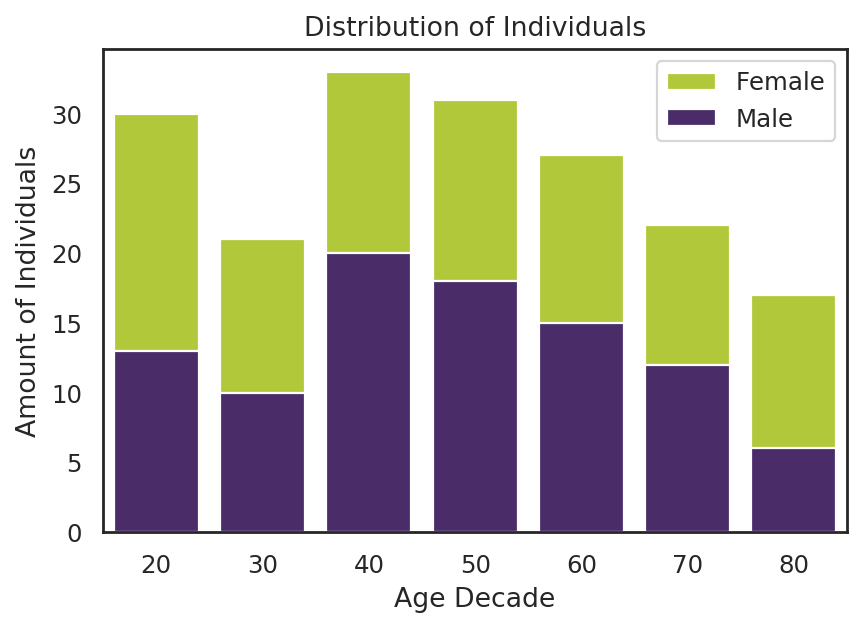

In [8]:
sns.set(style="white")
sns.barplot(data=df, x=df.index, y="Total", color=sns.color_palette("viridis", 10)[9], label="Female");
sns.barplot(data=df, x=df.index, y="Male", color=sns.color_palette("viridis", 10)[0], label="Male");
plt.ylabel('Amount of Individuals');
plt.xlabel('Age Decade');
plt.title('Distribution of Individuals');
plt.legend();

### Example Recording

In [9]:
idx = 8

In [10]:
recordings[idx]

{'Gender': 'm',
 'AgeDecade': '20',
 'RecordingStartTime': datetime.time(14, 16),
 'Series':        ContractionNo  ContractionNoNorm  RrInterval
 0              52485                  0       720.0
 1              52486                  1       712.0
 2              52487                  2       744.0
 3              52488                  3       752.0
 4              52489                  4       784.0
 ...              ...                ...         ...
 21928          74413              21928      1088.0
 21929          74414              21929      1008.0
 21930          74415              21930      1128.0
 21931          74416              21931      1072.0
 21932          74417              21932      1008.0
 
 [21933 rows x 3 columns]}

### Plotted as Time Series

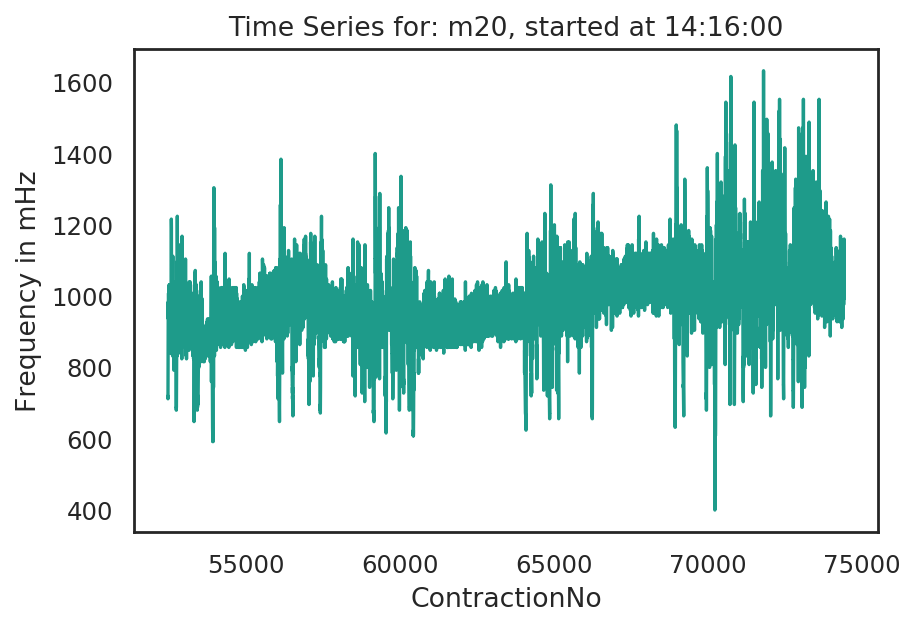

In [32]:
sns.lineplot(recordings[idx]["Series"]["ContractionNo"], recordings[idx]["Series"]["RrInterval"], color=color);
plt.ylabel('Frequency in mHz');
plt.xlabel('ContractionNo');
plt.title('Time Series for: {}{}, started at {}'.format(recordings[idx]["Gender"], recordings[idx]["AgeDecade"], recordings[idx]["RecordingStartTime"]));

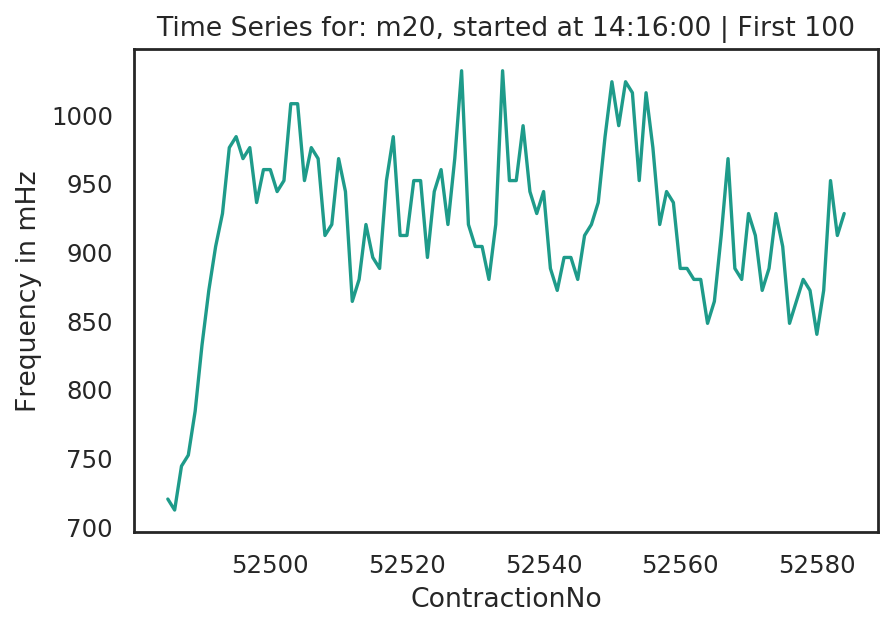

In [12]:
sns.lineplot(recordings[idx]["Series"]["ContractionNo"].head(100), recordings[idx]["Series"]["RrInterval"].head(100), color=color);
plt.ylabel('Frequency in mHz');
plt.xlabel('ContractionNo');
plt.title('Time Series for: {}{}, started at {} | First 100'.format(recordings[idx]["Gender"], recordings[idx]["AgeDecade"], recordings[idx]["RecordingStartTime"]));

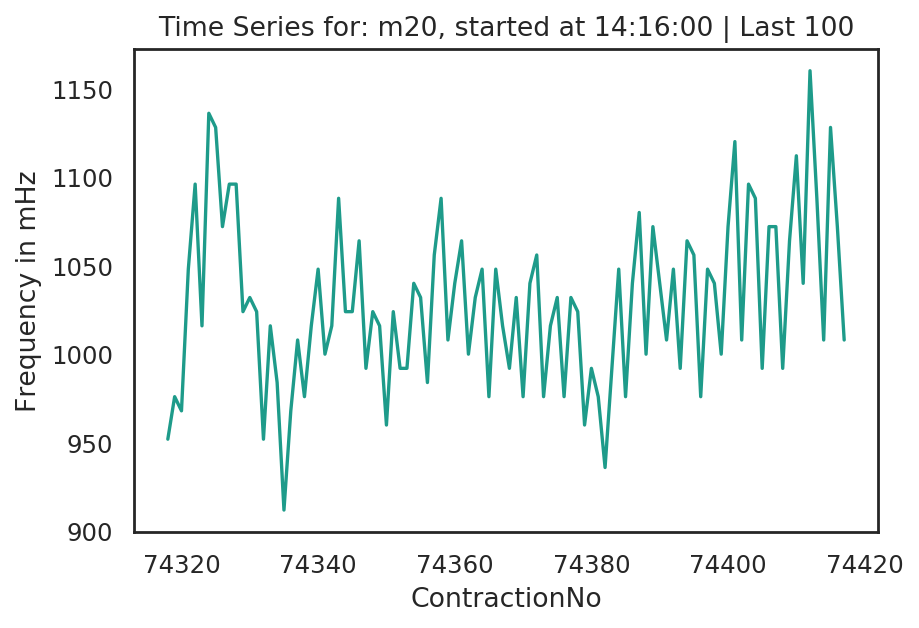

In [13]:
sns.lineplot(recordings[idx]["Series"]["ContractionNo"].tail(100), recordings[idx]["Series"]["RrInterval"].tail(100), color=color);
plt.ylabel('Frequency in mHz');
plt.xlabel('ContractionNo');
plt.title('Time Series for: {}{}, started at {} | Last 100'.format(recordings[idx]["Gender"], recordings[idx]["AgeDecade"], recordings[idx]["RecordingStartTime"]));

### Distribution of Recording Length

#### Histogram

In [14]:
recording_lengths = [recording["Series"].shape[0] for recording in recordings]

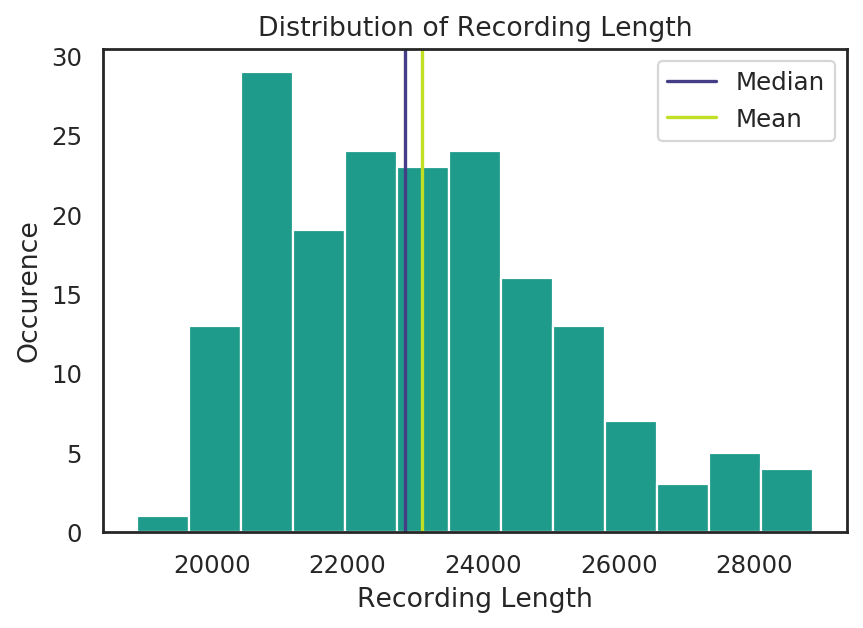

In [15]:
sns.distplot(recording_lengths, kde=False, bins=int(np.sqrt(len(recording_lengths))), color=color, hist_kws={"alpha": 1.0});
plt.axvline(x=np.median(recording_lengths), label="Median", color=sns.color_palette("viridis", 10)[1])
plt.axvline(x=np.mean(recording_lengths), label="Mean", color=sns.color_palette("viridis", 10)[9])
plt.ylabel('Occurence');
plt.xlabel('Recording Length');
plt.legend();
plt.title('Distribution of Recording Length');

#### Median

In [16]:
np.median(recording_lengths)

22852.0

#### Mean

In [17]:
np.mean(recording_lengths)

23094.60220994475

In [18]:
np.quantile(recording_lengths, [0.9, 0.95, 0.99])

array([25956., 26959., 28378.])

### Impurity

#### Global Percentage of Missing Data

In [19]:
%%time
overall_recordings = 0
overall_missing_data = 0

absolute = []
missing_in_recordings_absolute = []
missing_in_recordings_percentage = []

for recording in recordings:
    n = recording["Series"].shape[0]
    missing = len(recording["Series"]["RrInterval"]) - recording["Series"]["RrInterval"].count()

    overall_recordings += n
    overall_missing_data += missing
    
    absolute.append(n)
    missing_in_recordings_absolute.append(missing)
    missing_in_recordings_percentage.append(missing/n*100)

CPU times: user 34.3 ms, sys: 25 µs, total: 34.4 ms
Wall time: 33.2 ms


In [20]:
overall_recordings

4180123

In [21]:
overall_missing_data

1920

In [22]:
overall_missing_data / overall_recordings * 100

0.045931662776430265

In [23]:
overall_missing_data_df = pd.DataFrame({"absolute": absolute, "missing_absolute": missing_in_recordings_absolute, "missing_percentage": missing_in_recordings_percentage})
overall_missing_data_df.head(10)

,absolute,missing_absolute,missing_percentage
0,21802,9,0.041281
1,20430,0,0.000000
2,24864,9,0.036197
3,23411,0,0.000000
4,24392,78,0.319777
5,21377,0,0.000000
6,22132,7,0.031628
7,19769,18,0.091052
8,21933,87,0.396663
9,24191,0,0.000000


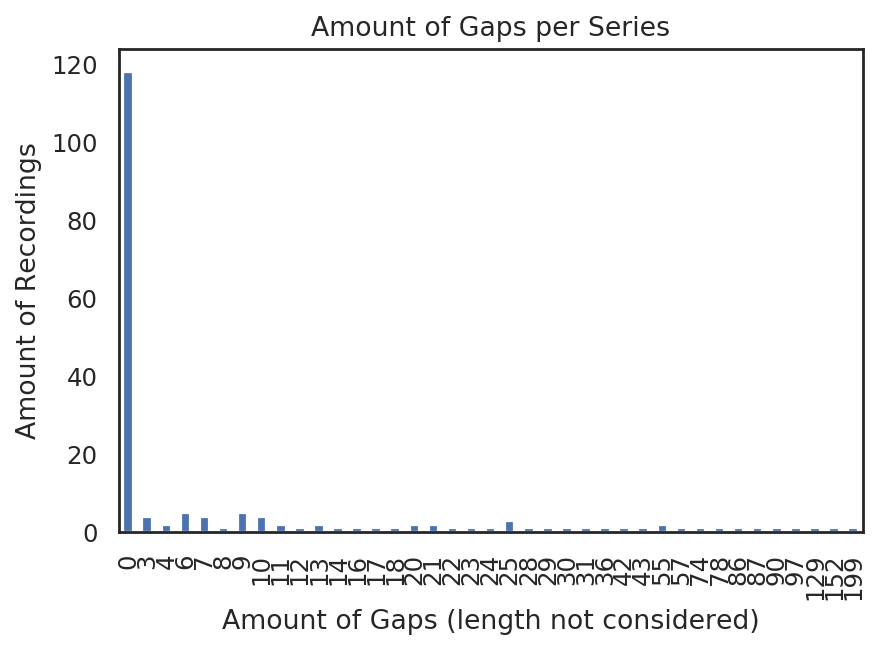

In [24]:
overall_missing_data_df['missing_absolute'].value_counts(normalize=False, sort=False).plot(kind='bar');
plt.ylabel('Amount of Recordings');
plt.xlabel('Amount of Gaps (length not considered)');
plt.title('Amount of Gaps per Series');

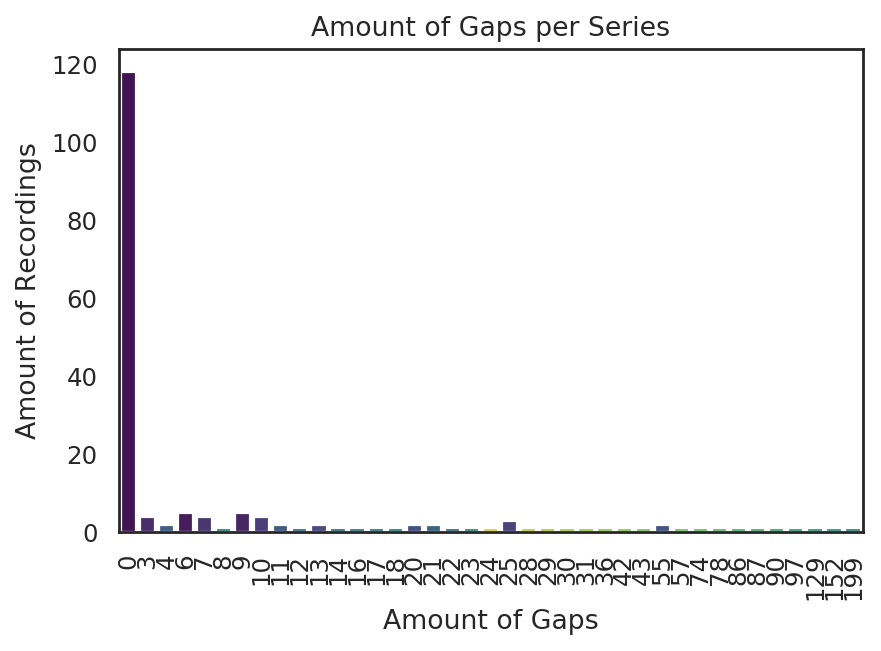

In [25]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

value_counts = overall_missing_data_df['missing_absolute'].value_counts(normalize=False, sort=False)

x = value_counts.index#[0:20]
y = value_counts.values#[0:20]

pal = sns.color_palette("viridis", len(y))
rank = y.argsort().argsort()
sns.barplot(x=x, y=y, palette=np.array(pal[::-1])[rank])
plt.xticks(rotation=90)
plt.ylabel('Amount of Recordings');
plt.xlabel('Amount of Gaps');
plt.title('Amount of Gaps per Series');
plt.show()

#### Length of Missing Data

In [26]:
def extract_recording_gap_length(recording):
    gap_counter = 0
    gap_lengths = []

    for index, row in recording["Series"].iterrows():
        if np.isnan(row["RrInterval"]):
            gap_counter += 1
        if not np.isnan(row["RrInterval"]) and gap_counter != 0:
            gap_lengths.append(gap_counter)
            gap_counter = 0
        
    return gap_lengths

In [27]:
%%time
import multiprocessing as mp
cores = mp.cpu_count()
pool = mp.Pool(cores)
all_gap_lengths_mp = pool.imap(extract_recording_gap_length, recordings)
pool.close()
pool.join()
all_gap_lengths_mp = list(all_gap_lengths_mp)

CPU times: user 229 ms, sys: 128 ms, total: 356 ms
Wall time: 1min 59s


In [28]:
from itertools import chain
gap_lengths_concatenated = list(chain.from_iterable(all_gap_lengths_mp))
gap_lengths_df = pd.DataFrame({"gap_length": gap_lengths_concatenated})
gap_lengths_df

,gap_length
0,9
1,9
2,11
3,7
4,10
...,...
235,9
236,6
237,9
238,3


Percentage of gaps being bigger than `limit`.

In [29]:
limit = 4
np.sum([1 if gap > limit else 0 for gap in gap_lengths_concatenated])/len(gap_lengths_concatenated)

0.8791666666666667

#### Lengths of Missing Data

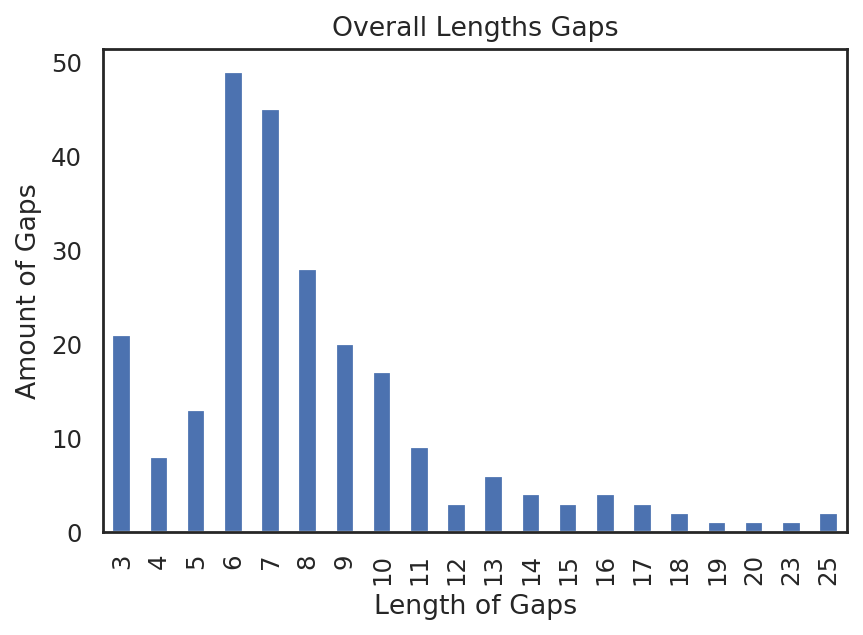

In [30]:
gap_lengths_df['gap_length'].value_counts(normalize=False, sort=False).plot(kind='bar');
plt.ylabel('Amount of Gaps');
plt.xlabel('Length of Gaps');
plt.title('Overall Lengths Gaps');

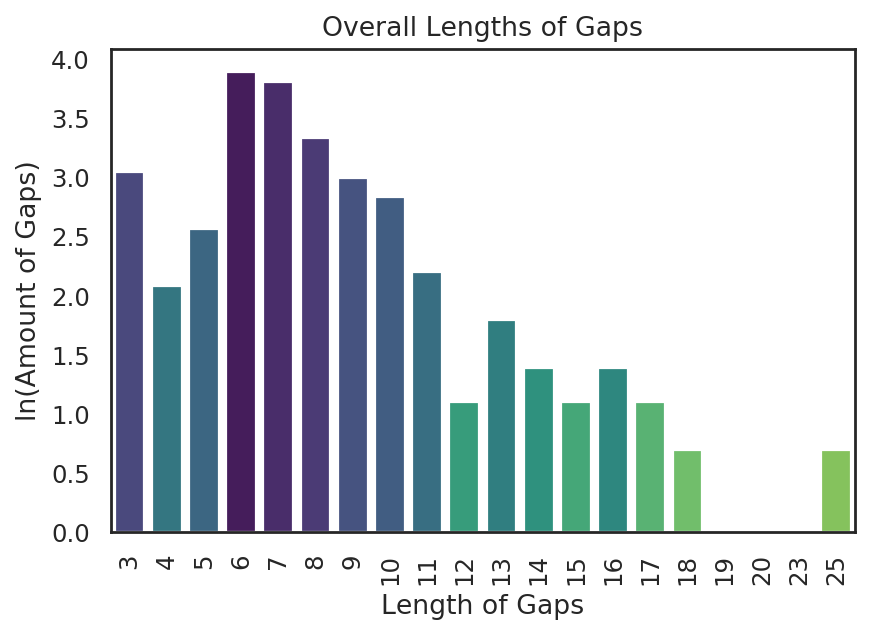

In [31]:
missing_data_counts = gap_lengths_df['gap_length'].value_counts(normalize=False, sort=False)

x = missing_data_counts.index#[0:20]
y = np.log(missing_data_counts.values)#[0:20]

pal = sns.color_palette("viridis", len(y))
rank = y.argsort().argsort()
sns.barplot(x=x, y=y, palette=np.array(pal[::-1])[rank])#, hue=x, dodge=False)
plt.ylabel('ln(Amount of Gaps)');
plt.xlabel('Length of Gaps');
plt.title('Overall Lengths of Gaps');
plt.xticks(rotation=90)
plt.show()